In [97]:
# import sys
sys.path.append("../code/")
import util_ElasticNet, lib_LinearAlgebra, util_hdf5, util_Stats, lib_cnnPTRS, util_misc
import tensorflow as tf
import numpy as np
import pandas as pd
import h5py, yaml, functools
import matplotlib.pyplot as plt
from importlib import reload
lib_LinearAlgebra = reload(lib_LinearAlgebra)
util_hdf5 = reload(util_hdf5)
util_Stats = reload(util_Stats)
lib_cnnPTRS = reload(lib_cnnPTRS)
util_misc = reload(util_misc)
import logging, sys, re
import seaborn as sns
logging.basicConfig(
    level = logging.INFO, 
    stream = sys.stderr,
#     filename = logfile,
    format = '%(asctime)s  %(message)s',
    datefmt = '%Y-%m-%d %I:%M:%S %p'
)


# Overview

We've trained a CNN and here we'd like to compute the PTRS on held out Britishs and other populations. 

So, we have one PTRS nsample x ntrait matrix for each population. 


# Load spatial information

In [56]:
def get_tss(start, end, strand):
    if strand == '+':
        return start
    else:
        return end
def chr2num(chrm):
    if 'X' in chrm:
        chrm = 23
    elif 'Y' in chrm:
        chrm = 24
    elif 'M' in chrm:
        chrm = 25
    else:
        chrm = int(re.sub('chr', '', chrm))
    return chrm

df_gene = pd.read_table('https://bitbucket.org/yanyul/rotation-at-imlab/raw/85a3fbe8f08df7c67265fed69569b7ea554d4e12/data/annotations_gencode_v26.tsv')


df_gene['tss'] = df_gene[['start', 'end', 'strand']].apply(lambda x: get_tss(x.start, x.end, x.strand), axis = 1)

df_gene['chr_num'] = df_gene[['chromosome']].apply(lambda x: chr2num(x.chromosome), axis = 1)

df_gene.sort_values(['chr_num', 'tss'], ascending = [True, True], inplace = True) 

df_gene = df_gene.reset_index(drop = True)

df_gene['rank'] = df_gene.index

In [57]:
with h5py.File(f'/vol/bmd/yanyul/UKB/predicted_expression_tf2/ukb_imp_x_ctimp_Whole_Blood_British.hdf5', 'r') as f:
    col_genes = f['columns_x'][...]
col_genes_cleaned = [ i.astype(str).split('.')[0] for i in col_genes ]
df_col_genes = pd.DataFrame({'gene_id': col_genes_cleaned, 'col_idx': [ i for i in range(len(col_genes_cleaned)) ]})

df_gene_joined = df_gene.join(df_col_genes.set_index('gene_id'), on = 'gene_id')

df_gene_joined = df_gene_joined.loc[df_gene_joined['gene_id'].isin(df_col_genes['gene_id'].to_list())].reset_index(drop = True)


x_indice = [ int(i) for i in df_gene_joined['col_idx'].to_list() ]

logging.info('Getting spatial data finished')

2020-02-17 11:18:51 AM  Getting spatial data finished


# Load predicted expression 

First load British and then load other populations.

In [58]:
population = 'British'

# set path to British data
hdf5_british = f'/vol/bmd/yanyul/UKB/predicted_expression_tf2/ukb_imp_x_ctimp_Whole_Blood_{population}.hdf5'

# data scheme specifying which are traits and covariates
scheme_yaml = '../misc_files/data_scheme.yaml'

# loading names of traits/covariates
# the order is matched with the data being loaded
feature_dic = util_hdf5.read_yaml(scheme_yaml)
with h5py.File(hdf5_british, 'r') as f:
    features = f['columns_y'][:].astype('str')
    sample_size = f['y'].shape[0]
    y = f['y'][:]
covar_indice = np.where(np.isin(features, feature_dic['covar_names']))[0]
trait_indice = np.where(np.isin(features, feature_dic['outcome_names']))[0]

# load data_scheme for training
batch_size = 2 ** 12
print(f'batch_size in British set is {batch_size}')
data_scheme, sample_size = util_hdf5.build_data_scheme(
    hdf5_british, 
    scheme_yaml, 
    batch_size = batch_size, 
    inv_norm_y = True
)


### IMPORTANT ###
# set x_indice
data_scheme.x_indice = x_indice

# set validation and test set as the first and second batch
dataset_valid = data_scheme.dataset.take(1)
data_scheme.dataset = data_scheme.dataset.skip(1)
dataset_test = data_scheme.dataset.take(1)
data_scheme.dataset = data_scheme.dataset.skip(1)
dataset_insample = data_scheme.dataset.take(1)

batch_size in British set is 4096


In [59]:
logging.info('Preparing tensors')
ele_test = util_misc.get_inputs_and_y(dataset_test, data_scheme.get_num_outcome())
ele_insample = util_misc.get_inputs_and_y(dataset_insample, data_scheme.get_num_outcome())
ele_valid = util_misc.get_inputs_and_y(dataset_valid, data_scheme.get_num_outcome())

2020-02-17 11:18:56 AM  Preparing tensors


Load other populations.

In [60]:
test_datasets = {
    'British_validation': ele_valid,
    'British_test': ele_test,
    'British_insample': ele_insample,
    'Chinese': None,
    'Indian': None,
    'African': None
}
batch_size_here = 8096
for i in test_datasets.keys():
    if 'British' not in i:
        filename = f'/vol/bmd/yanyul/UKB/predicted_expression_tf2/ukb_imp_x_ctimp_Whole_Blood_{i}.hdf5'
        logging.info(f'Preparing {i} tensors')
        data_scheme, sample_size = util_hdf5.build_data_scheme(
            filename, 
            scheme_yaml, 
            batch_size = batch_size_here, 
            inv_norm_y = True
        )
        data_scheme.x_indice = x_indice
        test_datasets[i] = util_misc.get_inputs_and_y(data_scheme.dataset, data_scheme.get_num_outcome())

2020-02-17 11:18:59 AM  Preparing Chinese tensors
2020-02-17 11:18:59 AM  Preparing Indian tensors
2020-02-17 11:19:00 AM  Preparing African tensors


# Load models

I mistook the saving method in training, so here it is the non-standard way to load model.

In [61]:
cnn_model = util_misc.load_ordered_yaml('../misc_files/cnn_ptrs.yaml')
cnn = lib_cnnPTRS.cnnPTRS(cnn_model, data_scheme, 'tmp_cnnPTRS_phase1_ctimp_Whole_Blood.h5', normalizer = True)

In [62]:
cnn.model = tf.keras.models.load_model('/vol/bmd/yanyul/UKB/ptrs-tf/models/cnnPTRS_phase2_British_ctimp_Whole_Blood.h5')

2020-02-17 11:19:03 AM  No training configuration found in save file: the model was *not* compiled. Compile it manually.


In [63]:
cnn.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 7044, 1)]    0                                            
__________________________________________________________________________________________________
layer1_conv (Conv1D)            (None, 7041, 16)     80          input_1[0][0]                    
__________________________________________________________________________________________________
layer1_maxpool (MaxPooling1D)   (None, 1760, 16)     0           layer1_conv[0][0]                
__________________________________________________________________________________________________
layer1_dropout (Dropout)        (None, 1760, 16)     0           layer1_maxpool[0][0]             
______________________________________________________________________________________________

# Calculate PTRS 

In [117]:
ytest_px, ytest = cnn.predict_x(ele_insample) # test_datasets['British_insample'])

In [118]:
print(cnn._cor_tf(ytest, ytest_px))

tf.Tensor(
[0.03703494 0.05267016 0.03093115 0.02466411 0.06011076 0.0577314
 0.06203322 0.04901799 0.1118964  0.12332213 0.08507172 0.05422905
 0.07822116 0.07011168 0.04543868 0.03575076 0.02174601], shape=(17,), dtype=float32)


In [119]:
# cnn.data_scheme.x_indice

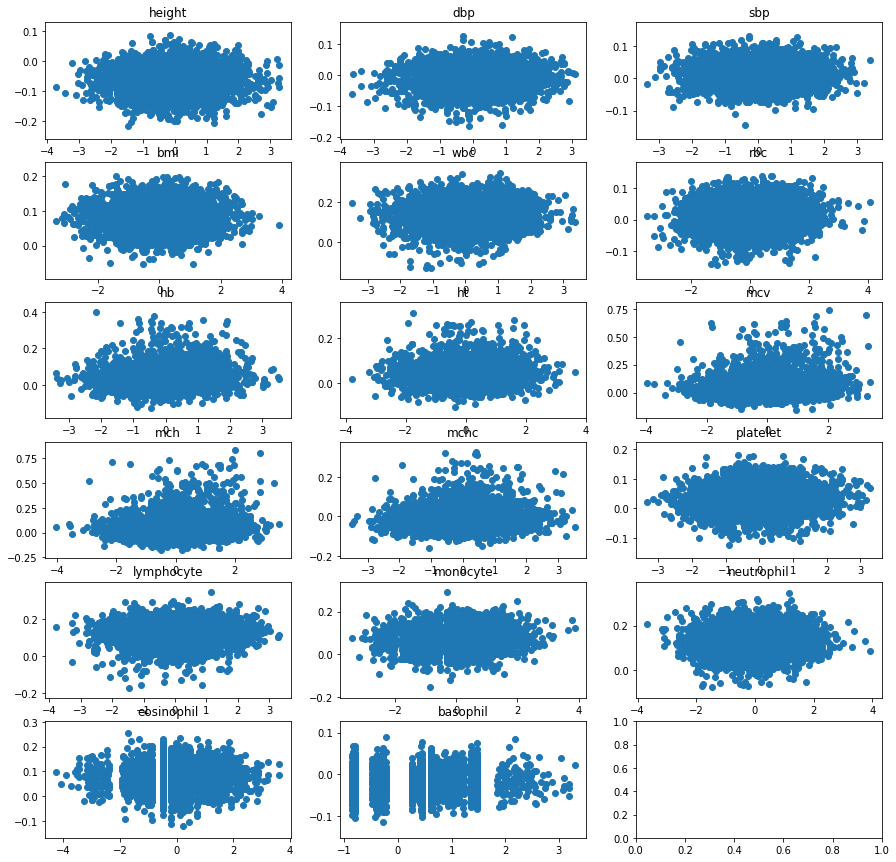

In [120]:
# out = o1
fig, aes = plt.subplots(nrows = 6, ncols = 3, figsize = (15, 15))
for i in range(6):
    for j in range(3):
        idx = (i * 3 + j)
        if idx < ytest_px.shape[1]:
            aes[i][j].scatter(ytest[:, idx], ytest_px[:, idx])
            aes[i][j].set_title(features[trait_indice[idx]]) 
            

# Calculate partial R2

In [112]:
partial_r2 = {}
for i in test_datasets.keys():
    ele = test_datasets[i]
    x, y = ele 
    covar = y.numpy()[:, cnn.data_scheme.covariate_indice]
    print('trait = {}, ncol(covar) = {}'.format(i, covar.shape[1]))
    y, ypred = cnn.predict_x(ele)
    partial_r2[i] = util_Stats.quick_partial_r2(covar, y, ypred.numpy()[:, :, np.newaxis])

trait = British_validation, ncol(covar) = 25
(26, 26)
trait = British_test, ncol(covar) = 25
(26, 26)
trait = British_insample, ncol(covar) = 25
(26, 26)
trait = Chinese, ncol(covar) = 25
(26, 26)
trait = Indian, ncol(covar) = 25
(26, 26)
trait = African, ncol(covar) = 25
(26, 26)


In [105]:
# y

<tf.Tensor: shape=(4096, 42), dtype=float32, numpy=
array([[ 4.10000e+01,  1.00000e+00, -1.21725e+01, ...,  1.68100e+03,
         4.10000e+01,  1.68100e+03],
       [ 4.60000e+01,  0.00000e+00, -1.30245e+01, ...,  2.11600e+03,
         0.00000e+00,  0.00000e+00],
       [ 5.20000e+01,  0.00000e+00, -1.14712e+01, ...,  2.70400e+03,
         0.00000e+00,  0.00000e+00],
       ...,
       [ 4.80000e+01,  1.00000e+00, -1.34193e+01, ...,  2.30400e+03,
         4.80000e+01,  2.30400e+03],
       [ 4.60000e+01,  0.00000e+00, -1.12841e+01, ...,  2.11600e+03,
         0.00000e+00,  0.00000e+00],
       [ 6.60000e+01,  0.00000e+00, -1.34466e+01, ...,  4.35600e+03,
         0.00000e+00,  0.00000e+00]], dtype=float32)>

In [103]:
# ele[1].shape

TensorShape([2835, 42])

In [113]:
partial_r2

{'British_validation': array([[1.73465040e-03],
        [1.41461209e-04],
        [1.10775828e-04],
        [1.82349722e-03],
        [3.19306901e-03],
        [5.08291228e-04],
        [3.70002122e-03],
        [2.12812864e-03],
        [4.30694641e-03],
        [7.75296553e-03],
        [1.40768542e-03],
        [1.23232662e-03],
        [2.63599045e-03],
        [7.54904002e-04],
        [1.91300265e-03],
        [3.96885595e-03],
        [4.63952010e-05]]), 'British_test': array([[5.32873315e-03],
        [1.36674732e-04],
        [1.06116714e-04],
        [4.67763792e-04],
        [1.59896379e-03],
        [4.92027490e-04],
        [3.38599085e-03],
        [2.21211113e-03],
        [8.64255227e-03],
        [1.22740133e-02],
        [1.53591710e-03],
        [7.98229978e-05],
        [1.80999833e-03],
        [8.59852987e-04],
        [4.16707839e-04],
        [1.86629716e-03],
        [1.01418005e-04]]), 'British_insample': array([[0.0016985 ],
        [0.00274833],
        [0.0

In [114]:
def _pr2_format(ele, features, name):
    return pd.DataFrame({'partial_r2': ele, 'trait': features, 'sample': name})
df = pd.DataFrame({'partial_r2': [], 'trait': [], 'sample': []})
for i in partial_r2.keys():
    df = pd.concat((df, _pr2_format(partial_r2[i][:, 0], features[trait_indice], i)))

In [115]:
df

,partial_r2,trait,sample
0,0.001735,height,British_validation
1,0.000141,dbp,British_validation
2,0.000111,sbp,British_validation
3,0.001823,bmi,British_validation
4,0.003193,wbc,British_validation
...,...,...,...
12,0.000520,lymphocyte,African
13,0.000003,monocyte,African
14,0.000085,neutrophil,African
15,0.000057,eosinophil,African


In [95]:
df.to_csv('/vol/bmd/yanyul/UKB/ptrs-tf/models/partial_r2-cnn_British.tsv', sep = '\t', index = False)

# Quick show

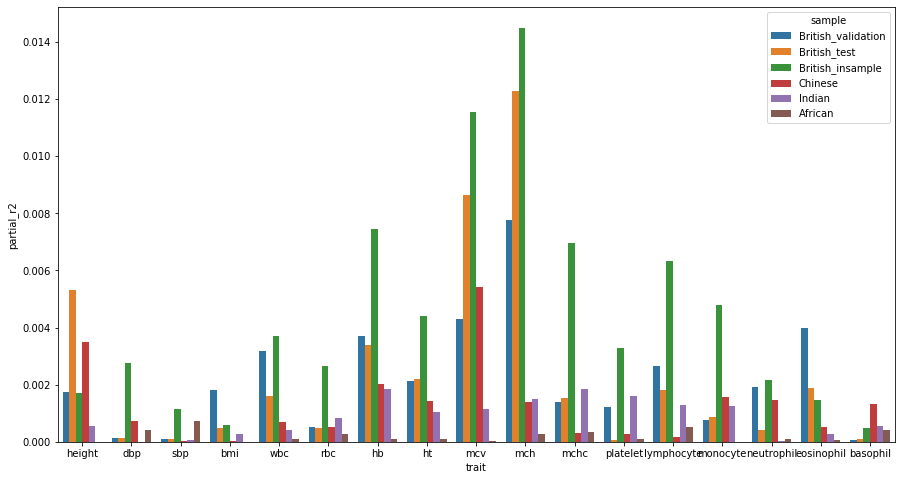

In [116]:
plt.figure(figsize=(15,8))
sns.barplot(x = "trait", y = "partial_r2", hue = 'sample', data = df)
